# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [1]:
! pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

^C


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'
env: DISPLAY=:1


"bash" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


### Experiment setup
* Here we simply load the game and check that it works

In [3]:
import gym
make_env = lambda: gym.make("Acrobot-v1")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

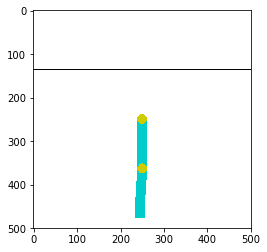

In [4]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [7]:
import lasagne
from lasagne.layers import *
#from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(observation_layer,num_units=100,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [8]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


ImportError: cannot import name 'standardize'

### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [ ]:
from agentnet.agent import Agent
agent = Agent(observation_layers=<which layer?>,
              action_layers=<which layer?>
              policy_estimators=qvalues_layer,)


In [ ]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [ ]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

In [ ]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

In [ ]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [ ]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [ ]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [ ]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [ ]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [ ]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = -90

In [ ]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

In [ ]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda (k,v):k))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [ ]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices